<a href="https://colab.research.google.com/github/Meowmixforme/Kaggle_Machine_Learning_Projects/blob/main/Project%204%20Cats%20vs%20Dogs/Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cats vs Dogs
Author: James Fothergill

In [55]:
# Import packages

# Dataset at https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification

import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import zipfile

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [50]:
# upload json APK from kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (6).json


In [51]:
# Install Kaggle CLI
!pip install -q kaggle

In [52]:
# Download and extract dataset
!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification

import zipfile
with zipfile.ZipFile("cats-and-dogs-image-classification.zip", "r") as zip_ref:
    zip_ref.extractall("cats_and_dogs_data")

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification
License(s): CC0-1.0
cats-and-dogs-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [53]:
# Build DataFrames from extracted data
def gather_df(image_root):
    filepaths = []
    labels = []
    for label in ["cats", "dogs"]:
        folder = image_root / label
        if not folder.exists():
            print(f"Warning: {folder} does not exist")
            continue
        for fp in folder.glob("*.jpg"):
            filepaths.append(str(fp))
            labels.append(label[:-1].capitalize())  # 'cats'->'Cat', 'dogs'->'Dog'
    return pd.DataFrame({"Filepath": filepaths, "Label": labels})

train_dir = Path("cats_and_dogs_data/train")
test_dir  = Path("cats_and_dogs_data/test")
train_df = gather_df(train_dir)
test_df  = gather_df(test_dir)

print("Train DataFrame shape:", train_df.shape)
print("Train labels:", train_df["Label"].unique())
print("Sample train_df:\n", train_df.head())
print("\nTest DataFrame shape:", test_df.shape)
print("Test labels:", test_df["Label"].unique())
print("Sample test_df:\n", test_df.head())

Train DataFrame shape: (557, 2)
Train labels: ['Cat' 'Dog']
Sample train_df:
                                     Filepath Label
0  cats_and_dogs_data/train/cats/cat_450.jpg   Cat
1  cats_and_dogs_data/train/cats/cat_260.jpg   Cat
2  cats_and_dogs_data/train/cats/cat_591.jpg   Cat
3  cats_and_dogs_data/train/cats/cat_149.jpg   Cat
4  cats_and_dogs_data/train/cats/cat_243.jpg   Cat

Test DataFrame shape: (140, 2)
Test labels: ['Cat' 'Dog']
Sample test_df:
                                    Filepath Label
0  cats_and_dogs_data/test/cats/cat_520.jpg   Cat
1  cats_and_dogs_data/test/cats/cat_342.jpg   Cat
2  cats_and_dogs_data/test/cats/cat_341.jpg   Cat
3  cats_and_dogs_data/test/cats/cat_417.jpg   Cat
4   cats_and_dogs_data/test/cats/cat_18.jpg   Cat


In [56]:
# Split the data
train_split, val_split = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df["Label"]
)

# use train_split and val_split
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_images = train_gen.flow_from_dataframe(
    train_split,
    x_col="Filepath",
    y_col="Label",
    target_size=(224,224),
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=42
)
val_images = val_gen.flow_from_dataframe(
    val_split,
    x_col="Filepath",
    y_col="Label",
    target_size=(224,224),
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 445 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.


In [57]:
# Build and compile the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,953 (101.38 KB)

 Trainable params: 25,953 (101.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3)
    ]
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5008 - loss: 0.6941 - val_accuracy: 0.4911 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4862 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5014 - loss: 0.6930 - val_accuracy: 0.5089 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5317 - loss: 0.6909 - val_accuracy: 0.4821 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6227 - loss: 0.6842 - val_accuracy: 0.5357 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5411 - loss: 0.6848 - val_accuracy: 0.5000 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5770 - loss: 0.6762 - val_acc

In [ ]:
# Evaluation
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step


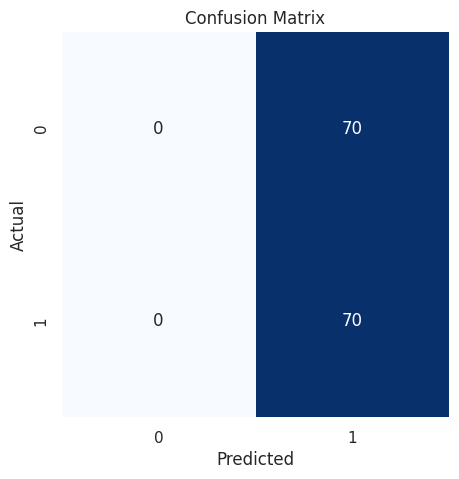

Classification Report:
               precision    recall  f1-score   support

         Cat       0.00      0.00      0.00        70
         Dog       0.50      1.00      0.67        70

    accuracy                           0.50       140
   macro avg       0.25      0.50      0.33       140
weighted avg       0.25      0.50      0.33       140



In [47]:
# Confusion matrix and classification report
preds = (model.predict(test_images) >= 0.5).astype(int).reshape(-1)
actuals = test_images.classes

cm = confusion_matrix(actuals, preds, labels=[0, 1])
clr = classification_report(actuals, preds, target_names=["Cat", "Dog"])

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", clr)

In [48]:
# Simulate the split done internally by ImageDataGenerator
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["Label"])
print("Train split counts:\n", train["Label"].value_counts())
print("Val split counts:\n", val["Label"].value_counts())

Train split counts:
 Label
Cat    223
Dog    222
Name: count, dtype: int64
Val split counts:
 Label
Dog    56
Cat    56
Name: count, dtype: int64
